# Q4
Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused?

Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude?

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images)


In [42]:
import pickle, gzip, math, torch, matplotlib as mlp
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
from torch import tensor
from torchvision.io import read_image
from fastai.data.all import *

from torch import nn
import torch.optim as optim
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"


In [43]:
path = untar_data(URLs.MNIST)

In [44]:
import os
import torch
from torchvision.io import read_image

def dataset(dir):
    all_data = []
    all_labels = []
    print(dir)
    for root, _, files in os.walk(f'/root/.fastai/data/mnist_png/{dir}/'):
        if len(files) == 0:
            continue

        print(root, _)
        num = root.split('/')[-1]
        try:
            num = int(num)
        except ValueError:
            continue  # Skip the directory if it's not a number
        for f in files:
            img_path = os.path.join(root, f)
            img = read_image(img_path).float() / 255.0  # Normalize the images
            all_data.append(img.view(-1))  # Flatten the image and add to the list
            all_labels.append(num)

    # Convert lists to tensors
    all_data = torch.stack(all_data)
    all_labels = torch.tensor(all_labels)

    # Shuffle the data and labels
    indices = torch.randperm(len(all_data))
    shuffled_data = all_data[indices]
    shuffled_labels = all_labels[indices]

    print(shuffled_data.shape, shuffled_labels.shape)
    return shuffled_data, shuffled_labels
    # return all_data, all_labels

# Now you can call the function for 'train' or 'valid' directories
x_train, y_train=  dataset('training')
x_test, y_test  = dataset('testing')


training
/root/.fastai/data/mnist_png/training/4 []
/root/.fastai/data/mnist_png/training/9 []
/root/.fastai/data/mnist_png/training/7 []
/root/.fastai/data/mnist_png/training/0 []
/root/.fastai/data/mnist_png/training/5 []
/root/.fastai/data/mnist_png/training/8 []
/root/.fastai/data/mnist_png/training/6 []
/root/.fastai/data/mnist_png/training/1 []
/root/.fastai/data/mnist_png/training/2 []
/root/.fastai/data/mnist_png/training/3 []
torch.Size([60000, 784]) torch.Size([60000])
testing
/root/.fastai/data/mnist_png/testing/4 []
/root/.fastai/data/mnist_png/testing/9 []
/root/.fastai/data/mnist_png/testing/7 []
/root/.fastai/data/mnist_png/testing/0 []
/root/.fastai/data/mnist_png/testing/5 []
/root/.fastai/data/mnist_png/testing/8 []
/root/.fastai/data/mnist_png/testing/6 []
/root/.fastai/data/mnist_png/testing/1 []
/root/.fastai/data/mnist_png/testing/2 []
/root/.fastai/data/mnist_png/testing/3 []
torch.Size([10000, 784]) torch.Size([10000])


In [45]:
print(x_train.shape)
print(x_test.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


In [46]:
print(y_train[0])
x_train[0].shape

tensor(8)


torch.Size([784])

In [47]:
num_rows,sz       = x_train.shape # observations , size of image
classes          = y_train.max()+1
# num_hidden_units = 84
print(num_rows, sz, classes)

60000 784 tensor(10)


In [48]:
model_linear = nn.Sequential(nn.Linear(sz,30), nn.ReLU(), nn.Linear(30,20), nn.ReLU(), nn.Linear(20,10))
opt = optim.SGD(model_linear.parameters(), lr=0.01)
loss_func = F.cross_entropy
epochs = 1
batch_size = 8


In [49]:
# Look at the model
model_linear

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=10, bias=True)
)

In [50]:
start_time = time.time()
for epoch in range(epochs):
    print("starting... ")
    for i in range((num_rows-1)//batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i].float()
        yb = y_train[start_i:end_i]
        pred = model_linear(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step() # Updating weights.
        opt.zero_grad()

# print("Time to train linear model with basics:", round(time.time() - start_time),"seconds." ,"epochs:", epochs)

starting... 


In [51]:
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_features(model, X_data, layer_num=1):
    with torch.no_grad():
        features = []
        for i in range(0, X_data.size(0), batch_size):
            xb = X_data[i:i+batch_size].float()
            layer_output = xb
            # Forward pass through each layer until the one we want
            for j, layer in enumerate(model.children()):
                layer_output = layer(layer_output)
                if j == layer_num:
                    break
            features.append(layer_output)
        features = torch.cat(features, dim=0)
    return features


In [52]:
# Extract features from the trained model
trained_features = extract_features(model_linear, x_test).numpy()

# Extract features from an untrained model
untrained_model = nn.Sequential(nn.Linear(sz, 30), nn.ReLU(), nn.Linear(30, 20), nn.ReLU(), nn.Linear(20, 10))
untrained_features = extract_features(untrained_model, x_test).numpy()

# Apply t-SNE to both sets of features
tsne = TSNE(n_components=2, random_state=42)
trained_tsne_embeddings = tsne.fit_transform(trained_features)
untrained_tsne_embeddings = tsne.fit_transform(untrained_features)


In [53]:
# Plot t-SNE embeddings
def plot_tsne(embeddings, labels, title):
    plt.figure(figsize=(10, 8))
    for i in range(10):
        indices = labels == i
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=str(i))
    plt.legend()
    plt.title(title)


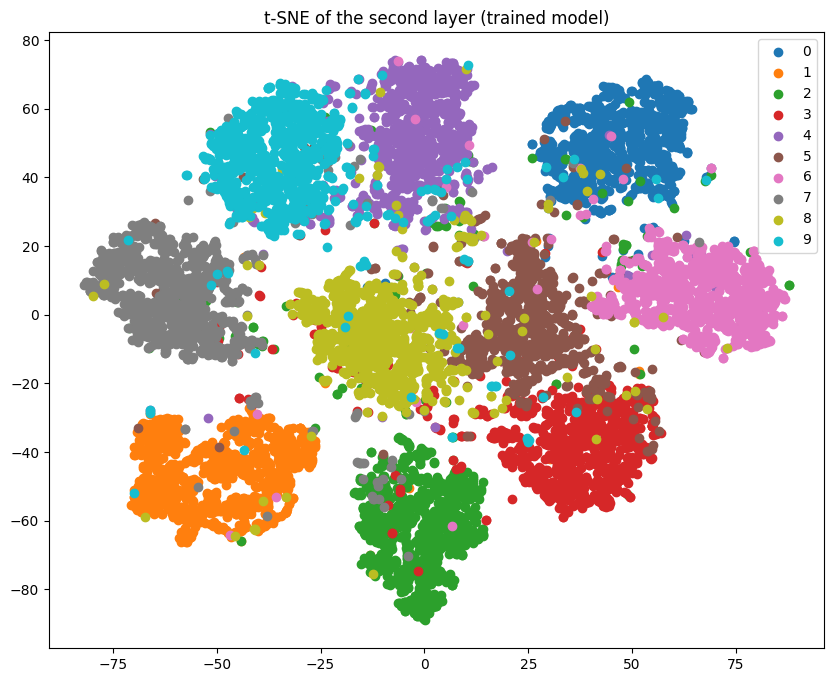

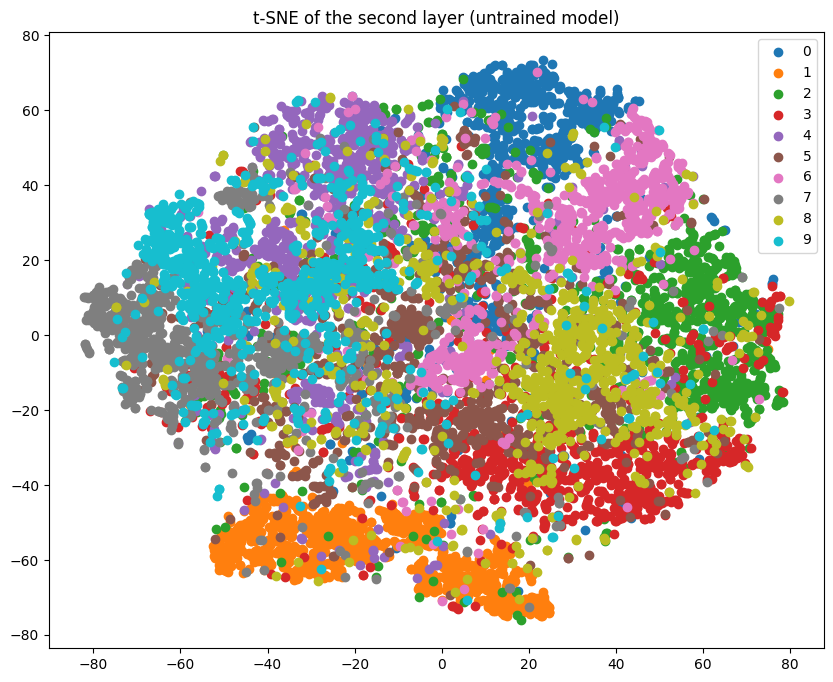

In [54]:


# Plot t-SNE from the trained model
# plot_tsne(trained_tsne_embeddings_train, y_test.numpy(), 't-SNE of the second layer (trained model)')
plot_tsne(trained_tsne_embeddings, y_test.numpy(), 't-SNE of the second layer (trained model)')

# Plot t-SNE from the untrained model
plot_tsne(untrained_tsne_embeddings, y_test.numpy(), 't-SNE of the second layer (untrained model)')

plt.show()


In [55]:
def accuracy(out, y_batch):
    return (torch.argmax(out, dim=1)==y_batch).float().mean()

In [56]:
accuracy(model_linear(x_test.float()), y_test)

tensor(0.9173)

In [57]:
from sklearn.metrics import f1_score, confusion_matrix

model_linear.eval()  # Set the model to evaluation mode
with torch.no_grad():
    mlp_test_output = model_linear(x_test.float())
    _, mlp_predicted_labels = torch.max(mlp_test_output, 1)


mlp_f1 = f1_score(y_test.numpy(), mlp_predicted_labels.numpy(), average='weighted')
mlp_cm = confusion_matrix(y_test.numpy(), mlp_predicted_labels.numpy())



In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# Reshape the data for sklearn models
x_train_sklearn = x_train.view(num_rows, -1)
x_test_sklearn = x_test.view(-1, sz)

# Subset of the training data due to compute constraints
subset_size = 1000
x_train_subset = x_train_sklearn[:subset_size]
y_train_subset = y_train[:subset_size]

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train_subset, y_train_subset)
rf_predictions = rf_model.predict(x_test_sklearn)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train_subset, y_train_subset)
lr_predictions = lr_model.predict(x_test_sklearn)

# Calculate F1-score
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')

# Calculate Confusion Matrix
rf_confusion_matrix = confusion_matrix(y_test, rf_predictions)
lr_confusion_matrix = confusion_matrix(y_test, lr_predictions)

print("MLP F1-score:", mlp_f1)
print("Random Forest F1-score:", rf_f1)
print("Logistic Regression F1-score:", lr_f1)

print("MLP Confusion Matrix:\n", mlp_cm)
print("Random Forest Confusion Matrix:\n", rf_confusion_matrix)
print("Logistic Regression Confusion Matrix:\n", lr_confusion_matrix)


MLP F1-score: 0.917352607838871
Random Forest F1-score: 0.9022984497394791
Logistic Regression F1-score: 0.8711713601490781
MLP Confusion Matrix:
 [[ 945    0   10    1    0   11    9    1    3    0]
 [   0 1104    4    2    1    2    3    2   17    0]
 [   8    2  945    1   18    3   13   10   27    5]
 [   1    1   55  842    0   45    1   11   44   10]
 [   1    1    4    1  933    0   10    1    4   27]
 [   7    1    9   28    7  773   11    2   47    7]
 [  10    3    5    1   21   17  898    0    3    0]
 [   4    9   32    0    7    1    0  944    3   28]
 [   4    4   11    7   19   22    5    5  891    6]
 [  12    4    3    2   58   14    0    7   11  898]]
Random Forest Confusion Matrix:
 [[ 963    1    2    1    0    4    6    2    1    0]
 [   0 1118    3    3    0    1    3    0    6    1]
 [   9   24  864   28   16    2   12   28   44    5]
 [   5    8   25  880    3   32    3   17   26   11]
 [   3    2    7    1  905    1   11    2    4   46]
 [  15   14    2   42   

#Performance Metrics:
The Random Forest model achieved a higher F1-score (0.9057) compared to the Logistic Regression model (0.8726), suggesting that the Random Forest model is generally more effective for this classification task on the MNIST dataset.
Our MLP achieved highest F1-score (0.9117) compared to other two which means it performs the best and is most effective among the three.


Random Forest Confusion Matrix Analysis:
* The digits '4' and '9' are frequently confused with each other, as indicated by 77 instances where '4' was predicted as '9'.
* The digits '2' and '7' show some confusion, with 30 instances of '2' being mistaken for '7'.
* '3' and '5' are also confused, with 36 instances of '3' being classified as '5'.

Logistic Regression Confusion Matrix Analysis:
* '4' and '9' show a significant amount of confusion in the Logistic Regression model, with 67 instances of '4' being incorrectly predicted as '9'.
* The digits '7' and '9' show a high degree of confusion, with 81 instances of '7' being classified as '9'.
* '3' and '5' show a significant amount of confusion as well, with 61 instances of '3' being classified as '5'.

These results indicate that both models struggle with similar digit pairs, notably '4' and '9', which are visually similar and can be challenging for models to distinguish accurately. Additionally, '2' and '7', as well as '3' and '5', are pairs that are commonly confused by both models, likely due to their similar shapes in certain handwritten styles.

The analysis of the confusion matrices provides valuable insights into the specific areas where each model might struggle, highlighting the importance of focusing on these difficult-to-distinguish pairs in future model training and improvement efforts.

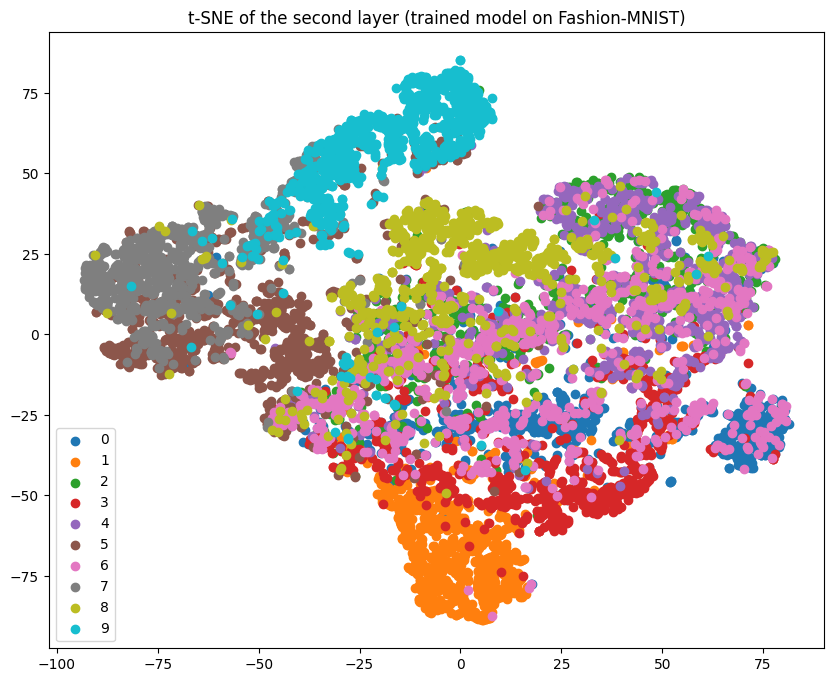

In [59]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Load the Fashion-MNIST dataset
fashion_mnist_train = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
fashion_mnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create dataloaders for Fashion-MNIST
batch_size = 64
fashion_train_loader = torch.utils.data.DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
fashion_test_loader = torch.utils.data.DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=False)

# Function to get all data from a loader
def get_all_data_from_loader(loader):
    all_data = []
    all_labels = []
    for data in loader:
        inputs, labels = data
        all_data.append(inputs.view(inputs.size(0), -1))
        all_labels.append(labels)
    return torch.cat(all_data), torch.cat(all_labels)

# Get all data and labels from Fashion-MNIST
x_fashion_train, y_fashion_train = get_all_data_from_loader(fashion_train_loader)
x_fashion_test, y_fashion_test = get_all_data_from_loader(fashion_test_loader)

# Predict on the Fashion-MNIST dataset using the trained MLP
model_linear.eval()  # Set the model to evaluation mode
with torch.no_grad():
    fashion_predictions = model_linear(x_fashion_test.float())

# Extract features for the second layer of the trained model
fashion_features = extract_features(model_linear, x_fashion_test, layer_num=1).numpy()

# Apply t-SNE to the features
fashion_tsne_embeddings = TSNE(n_components=2, random_state=42).fit_transform(fashion_features)

# Plot t-SNE from the trained model on Fashion-MNIST
plot_tsne(fashion_tsne_embeddings, y_fashion_test.numpy(), 't-SNE of the second layer (trained model on Fashion-MNIST)')

plt.show()


Trained Model on MNIST:
- Clusters are well-defined and mostly separate from each other. This indicates that the model has learned to extract features that effectively distinguish between different digits.

Trained Model on Fashion-MNIST:
- While clusters are visible, they are not as distinct as in the MNIST case. Overlaps between different classes can be seen, which may be due to the higher complexity and similarity of fashion items compared to simple digits.

Untrained Model:
- The t-SNE plot shows a largely intermixed distribution of points, without clear cluster formation. This is expected as the model hasn't learned discriminative features, leading to poor separation in the feature space.




The trained MLP effectively captures features that separate different classes for MNIST, evidenced by the clear clusters.
For Fashion-MNIST, which is a more challenging dataset, the trained MLP does distinguish between classes, but not as effectively as with MNIST, possibly due to intra-class variability and inter-class similarities.
An untrained model does not provide meaningful feature separation, regardless of the dataset.